# The representation of women in the movie industry around the world

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import os
import pycountry
import pycountry_convert as pc
import swifter

from functools import lru_cache
from scipy import stats
from itertools import islice
from wordcloud import WordCloud
from sklearn.linear_model import LinearRegression

from helpers_corenlp import *

/usr/local/anaconda3/envs/ada/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Table of content**

1. [Data scrapping and cleaning](#Data-scrapping-and-cleaning)
2. [Data pre-processing](#Data-pre-processing)
3. [Data Analysis](#Data-analysis)
    - [Part 1: Quantitative analysis of gender inequalities in movies](#part1)
    - [Part 2: Qualititative analysis of gender representation in movies](#part2)
    - [Part 3: Analysis of the reception of movies by the public](#part3)
    - [Part 4:  Analysis by geographical production region](#part4)

## STEP 1: DATA SCRAPPING AND CLEANING <a class="anchor" id="Data-scrapping-and-cleaning"></a>

---

In [2]:
current_directory = os.getcwd()

DATA_PATH = os.path.join(current_directory, 'MovieSummaries')
MOVIE_PATH = os.path.join(DATA_PATH, 'movie.metadata.tsv')
CHARACTER_PATH = os.path.join(DATA_PATH, 'character.metadata.tsv')
CHARACTER_TYPE_PATH = os.path.join(DATA_PATH, 'tvtropes.clusters.txt')
RATINGS_PATH = os.path.join(current_directory, 'Ratings_PreProcessed.tsv')

CORE_NLP_PATH = os.path.join(current_directory, 'corenlp')
CORE_NLP_GZ = CORE_NLP_PATH + "/corenlp_plot_summaries"
CORE_NLP_XML = CORE_NLP_PATH + "/corenlp_plot_summaries_xml"

IMDB_PATH = os.path.join(current_directory, 'IMDB')
IMDB_BASICS_PATH = IMDB_PATH + "/title.basics.tsv"
IMDB_RATINGS_PATH = IMDB_PATH + "/title.ratings.tsv"

BECHDEL_PATH = os.path.join(current_directory, 'bechdel_movies_2023_FEB.csv')

AWARDS_PATH = os.path.join(current_directory, '/the_oscar_award.csv')

#### CMU Movie Summary metadata

In [3]:
## INCLURE NOS NOTEBOOKS DE CLEANING

## STEP 2: DATA PRE-PROCESSING <a id="Data-pre-processing"></a>

---

#### CMU Movie Summary metadata

We will use the files movies.metadata.tsv and characters.metadata.tsv .

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='left', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate'])
cmu = cmu.drop('DoB', axis=1)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
268107,21621385,/m/05m_0h6,Jag Jeondeyan De Mele,2009-02-20,NaN,160.0,"{""/m/0688f"": ""Punjabi language""}","{""/m/03rk0"": ""India"", ""/m/0d060g"": ""Canada""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D...",NaN,M,NaN,NaN,Paramjit Gill,NaN,/m/0k6zvpg,NaN,/m/0k6zvpk
96793,71473,/m/0jdr0,The Third Man,1949-08-31,NaN,93.0,"{""/m/02h40lc"": ""English Language"", ""/m/06b_j"":...","{""/m/02jx1"": ""England"", ""/m/07ssc"": ""United Ki...","{""/m/01jfsb"": ""Thriller"", ""/m/09blyk"": ""Psycho...",Actor,M,NaN,NaN,Karel Štěpánek,NaN,/m/0h1n6jv,/m/0h1n6cv,/m/0dd92v0


In [6]:
from functions import convert_date

# Keep only the rows for which we have the gender of the actor/actress
cmu = cmu.loc[cmu['Gender'].isin(['F', 'M'])].copy(deep=True)

# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
cmu['ReleaseDate'] = cmu['ReleaseDate'].replace('1010-12-02', '2010-12-02')
# Convert the date in the column 'ReleaseDate' into datetime
ReleaseDate_datatime = cmu['ReleaseDate'].apply(convert_date)
# Add a column with the year of release only
cmu['ReleaseYear'] = ReleaseDate_datatime.dt.year.fillna(0).astype(int)
cmu['ReleaseYear'] = cmu['ReleaseYear'].astype('int64')
cmu['ReleaseYear'].replace(0, np.nan, inplace=True)

# Convert the str-like dictionaries to dictionaries
cmu['Countries'] = cmu['Countries'].apply(ast.literal_eval)
cmu['MovieGenre'] = cmu['MovieGenre'].apply(ast.literal_eval)
cmu['Languages'] = cmu['Languages'].apply(ast.literal_eval)

# Remove outliers for age and replace null or negative values by NaN
cmu['Age'] = cmu['Age'].apply(lambda x: np.nan if x <= 0 else x)

# Keep only movies between 1912 and 2012 to have at least 200 movies per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Keep only movies after 1925 to have at least 100 characters per year
cmu = cmu.loc[(cmu['ReleaseYear'] >= 1912) & (cmu['ReleaseYear'] <= 2012)]

# Drop outliers for height
Q1 = cmu['Height'].quantile(0.25)
Q3 = cmu['Height'].quantile(0.75)
IQR = Q3 - Q1
cmu = cmu[(cmu['Height'] > Q1 - 1.5 * IQR) & (cmu['Height'] < Q3 + 1.5 * IQR)]

# Drop outliers for Runtime
lower, upper = 40, 180
cmu = cmu[(cmu['Runtime'] >= lower) & (cmu['Runtime'] <= upper)]

In [7]:
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
370193,16247804,/m/03wd_4n,Oliver Twist,1982,NaN,103.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",Bill Sikes,M,1.75,/m/02w7gg,Tim Curry,35.0,/m/05cdqnr,/m/04g8j6,/m/07rzf,1982.0
32924,17551895,/m/047bl9d,Visioneers,2008-06-12,NaN,94.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/0vgkd': 'Black comedy', '/m/01z4y': 'Come...",Michelle,F,1.78,NaN,Judy Greer,32.0,/m/04dj62q,/m/0h16yj8,/m/08cn4_,2008.0


#### Processing the CoreNLP parsed movie summaries

We process the files contained in the corenlp_plot_summaries.tar archive.

All functions used for this part and other helpers are in the helpers_corenlp.py file.

In [8]:
# First we extract the files contained in the tar file into .xml files
load_corenlp_data()

From the Bamman et al. paper [1], we know what type of dependencies we need to look for in the plot summary trees:
- for agent verbs: verbs for which the entity is
   - nsubj
   - agent
- for patient verbs: verbs for which the entity is
   - dobj
   - nsubjpass
   - iobj
   - any prepositional argument prep_*
- for attributes: adjectives and common noun words that relate to the mention as adjecti- val modifiers, noun-noun compounds, appos- itives, or copulas: 
   - nsubj or appos governors of a character mention
   - nsubj, appos, amod, nn dependents of a character mention

This search is directly implemented in a function.

The idea is also to count the number of mentions of each character of a movie and then use this number of mentions as a proxy for identifying the main character. Thus in our case we define the main character as the moset mentioned one in the plot summary.

In [9]:
# get the Wikipedia movie id from the Lord of the Ring movies
test_ids = characters[characters['CharacterName'] == 'Aragorn']['WikiMovieID'].values

In [10]:
# get the main character names from the Lord of the Ring movies
for id in test_ids:
    movie_xml = str(id) + '.xml'
    print(get_main_character(movie_xml))

Frodo
Frodo Baggins
Frodo
Frodo


As we expect, we extract Frodo as the main character of all the Lord of the Ring movies.
But we see that depending on the plot summary, the character's full name extracted can be different...

We thus need to check in a bidirectional way what the "fullest" name used is between the name extracted from the summary and the one used in the character metadata before merging.

In [13]:
lst = []
# we only iterate over movies for which both character and movie metadata is available
ids = np.intersect1d(movies['WikiMovieID'].unique(), characters['WikiMovieID'].unique())
for id in ids[:100]:
    # We extract the data from the .xml files into a list of dictionaries
    if os.path.isfile(CORE_NLP_XML + '/' + str(id) + '.xml'):
        lst = lst + get_list_movie(str(id) + '.xml')
        cmu_characters = list(cmu[cmu['WikiMovieID'] == id].CharacterName)
        xml_characters = list(get_characters_from_xml(str(id) + '.xml'))
        characters = cmu_characters + xml_characters
        # type cast to string
        characters = [str(x) for x in characters]
        # get the full names of the characters
        dict = get_full_names_dict(characters)
        # replace cmu CharacterName by the full name in that movie
        cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'] = cmu.loc[cmu['WikiMovieID'] == id, 'CharacterName'].apply(lambda x: dict[x] if x in dict.keys() else x)

# We convert the list of dictionaries into a dataframe
df_corenlp = pd.DataFrame(lst)

df_corenlp.head()

,WikiMovieID,CharacterName,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,3217,Lord Arthur,None,None,None,3,False
1,3217,Henry,None,"enslaved, set",None,2,False
2,3217,Sheila,None,"attracted, captured, transformed, saving",None,4,True
3,3217,Ash,slays,"thrown, celebrated, pursues, determined, join",None,2,False
4,3217,Klaatu,None,say,None,1,False


The code takes a lot of time to run so for now we only do it for a few movies (for the first 100 IDs).

In [17]:
print(type(cmu.WikiMovieID[0]))
print(type(df_corenlp.WikiMovieID[0]))

<class 'numpy.int64'>
<class 'str'>


We need to typecast so that we can merge!

In [18]:
# change the type of the WikiMovieID column to int64
df_corenlp['WikiMovieID'] = df_corenlp['WikiMovieID'].astype('int64')

In [19]:
cmu_corenlp = cmu.merge(df_corenlp, how='inner', on=['WikiMovieID', 'CharacterName'])

In [20]:
cmu_corenlp.head()

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,...,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear,Agent verbs,Patient verbs,Attributes,Mentions,MainCharacter
0,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,90.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},"{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy'}",Dr. Strangelove,...,38.0,/m/02nwt1n,/m/02nwt1q,/m/063_t,1964.0,None,None,None,3,False
1,8695,/m/02dwj,Dr. Strangelove or: How I Learned to Stop Worr...,1964-01-29,9164370.0,90.0,"{'/m/02h40lc': 'English Language', '/m/06b_j':...",{'/m/07ssc': 'United Kingdom'},"{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy'}",Merkin Muffley,...,38.0,/m/05dc8rr,/m/02s2g7,/m/063_t,1964.0,gives,shocked,None,5,False
2,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,131.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",James Cole,...,40.0,/m/0k7f2_,/m/04drwvq,/m/0h7pj,1995.0,witnessing,"troubled, restrained, locked, interviewed, giv...","living, young",6,True
3,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,131.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Dr. Kathryn Railly,...,37.0,/m/0k7f34,/m/0h2ldj5,/m/01xldv,1995.0,spots,kidnaps,None,6,False
4,30575,/m/07j6w,Twelve Monkeys,1995-12-27,168839459.0,131.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Jeffrey Goines,...,32.0,/m/0k7f39,/m/04dk4xh,/m/0c6qh,1995.0,suggests,encounters,None,5,False


We get a dataframe with character information extracted from the movie plot summary joined with metadata from the CMU movie corpus. The information extracted from the CoreNLP parsed summaries will be used to cluster characters based on their depiction in the summary.

## Add geographical data to our dataset

In [106]:
#number of row in cmu
nb_row_countries = len(cmu)

# Remove the rows in the 'Countries' column that lack information about countries.
cmu = cmu[cmu['Countries'].apply(lambda x: len(x)!=0)].copy(deep=True)

In [107]:
num_rows_dropped = nb_row_countries-len(cmu)
percentage_rows_dropped = (num_rows_dropped / nb_row_countries) * 100
print(f'We dropped {num_rows_dropped} rows, corresponding to {percentage_rows_dropped:.2f}% of our dataset.')

We dropped 2023 rows, corresponding to 1.51% of our dataset.


In [108]:
# We convert the column type from dictionaries to a list of strings.
cmu['Countries'] = cmu['Countries'].apply(lambda x: [val for val in x.values()])

To facilitate the analysis, we will utilize the ISO databases available in the pycountry library for standardized country names.

In [109]:
from functions import bulkFindCountries

cmu['Countries'] = cmu['Countries'].swifter.apply(bulkFindCountries)

Pandas Apply:   0%|          | 0/131878 [00:00<?, ?it/s]

We keep only the countries for which we have the alpha_2 code

In [110]:
from functions import process_countries

length_before = len(cmu)

cmu['Countries'] = cmu['Countries'].apply(process_countries)
cmu = cmu.dropna(subset=['Countries'])

length_after = len(cmu)
print(f'We dropped {length_before-length_after} rows, corresponding to {((length_before-length_after)/length_before)*100:.2f}% of our dataset.')

We dropped 146 rows, corresponding to 0.11% of our dataset.


In [111]:
# Then we can determine the continent using the alpha_2 code
cmu['Continent'] = cmu['Countries'].apply(lambda x: [pc.country_alpha2_to_continent_code(country) for country in x])

In [112]:
# If a row contains multiple occurrences of the same continent, eliminate the duplicates within the list
cmu['Continent'] = cmu['Continent'].apply(lambda x: list(dict.fromkeys(x)) if isinstance(x, list) else x)

In [113]:
# Remove the rows for which we have more than one unique continent
length_before = len(cmu)

cmu_countries = cmu[cmu['Continent'].apply(lambda x: len(x) <= 1)]

length_after = len(cmu)
print(f'{length_before-length_after} rows were dropped')

0 rows were dropped


In [135]:
# Change the data type of the 'Continent' column from a list to a string since it now contains lists with only one element
cmu['Continent'] = cmu['Continent'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [141]:
# convert list in string
cmu['Countries'] = cmu['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear,Continent
97526,6725829,/m/0gks8b,A Private Matter,1992,NaN,92.0,{'/m/02h40lc': 'English Language'},US,"{'/m/0hj3n34': 'Feminist Film', '/m/07s9rl0': ...",Mary Beth,F,1.650,/m/0xnvg,Carla Gugino,20.0,/m/0cg1nzl,/m/0gxn1bp,/m/06qgvf,1992.0,NA
195117,5831848,/m/0f7_dk,Wristcutters: A Love Story,2006-01-24,460136.0,88.0,{'/m/02h40lc': 'English Language'},US,"{'/m/06cvj': 'Romantic comedy', '/m/0hj3n5y': ...",Mikal,F,1.715,/m/01qhm_,Shannyn Sossamon,27.0,/m/02vck0b,/m/0h0z69j,/m/036cd0,2006.0,NA


In [115]:
## INCLURE NOS NOTEBOOK DE PRE-PROCESSING

## STEP 3: DATA ANALYSIS <a id="Data-analysis"></a>

---

## PART 1: Quantitative analysis of gender inequalities in movies <a id="part1"></a>

We will start by analysing the main differences we can find between the representation of men and women in the movie industry.

### AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

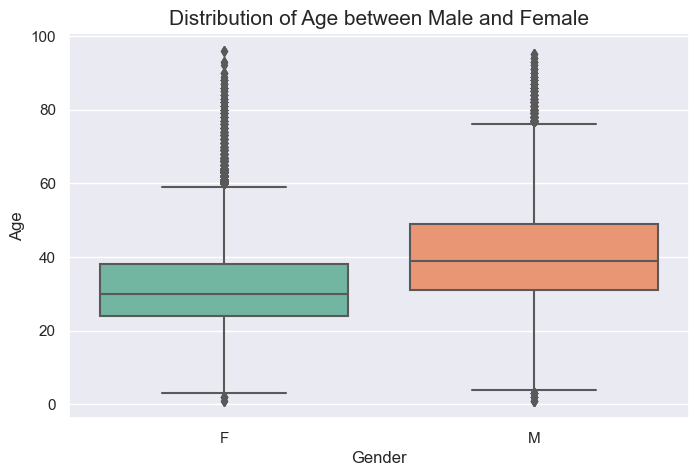

In [116]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [142]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [143]:
women_cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear,Continent
98815,1667811,/m/05l_gp,Embrace of the Vampire,1995-06-03,NaN,93.0,{'/m/02h40lc': 'English Language'},US,"{'/m/01q03': 'Cult', '/m/0glj9q': 'Erotic thri...",Marika,F,1.69,/m/04y8_bm,Jennifer Tilly,36.0,/m/02vct24,/m/0gz2f37,/m/03jjzf,1995.0,NA
418592,1343517,/m/04v99w,Head in the Clouds,2004,3510605.0,121.0,"{'/m/064_8sq': 'French Language', '/m/04306rv'...",US,"{'/m/0hn10': 'LGBT', '/m/04xvlr': 'Period piec...",Mia,F,1.68,/m/03ttfc,Penélope Cruz,29.0,/m/0jz7xq,/m/0gx8zck,/m/05q_b,2004.0,NA


In [144]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

Ttest_indResult(statistic=-103.3570344603936, pvalue=0.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.

### Has this tendency evolved with years ?

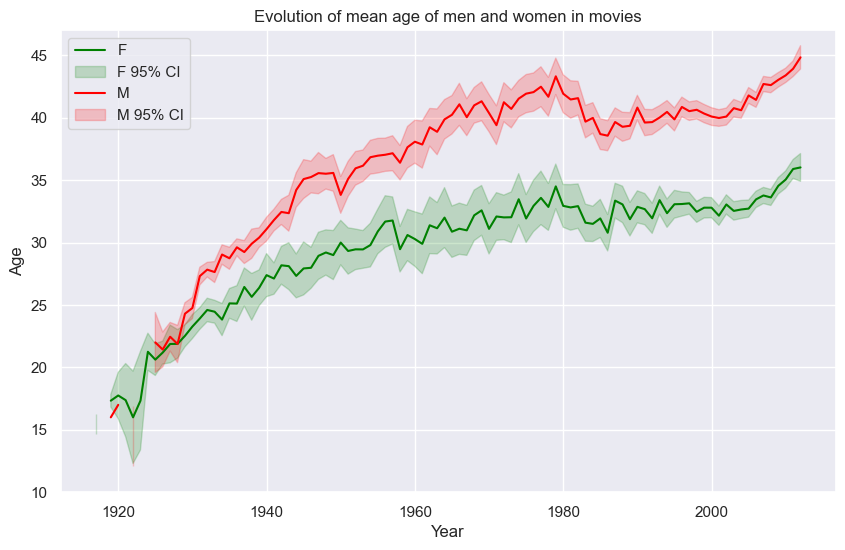

In [145]:
# Calculate the average age of actors and actresses in movies across year
women_mean_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})
men_mean_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'mean'})

# Calculate the 95% CIs
women_std_age_per_year = women_cmu.groupby('ReleaseYear').agg({'Age': 'std'})
men_std_age_per_year = men_cmu.groupby('ReleaseYear').agg({'Age': 'std'})

z=1.96
upper_bound_women = women_mean_age_per_year['Age'] + z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_women = women_mean_age_per_year['Age'] - z*women_std_age_per_year['Age']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

upper_bound_men = men_mean_age_per_year['Age'] + z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])
lower_bound_men = men_mean_age_per_year['Age'] - z*men_std_age_per_year['Age']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName' : 'count'})['CharacterName'])

# Plot the evolution of mean age of men and women in movies
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(women_mean_age_per_year, label='F', color='green')
ax.fill_between(women_mean_age_per_year.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(men_mean_age_per_year, label='M', color='red')
ax.fill_between(men_mean_age_per_year.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

ax.set_ylim(10,47)
ax.set_xlabel('Year')
ax.set_ylabel('Age')
ax.set_title('Evolution of mean age of men and women in movies')
ax.legend()

plt.show()

### PROPORTION OF FEMALE CHARACTERS

We will explore the proportion of female characters in movies.

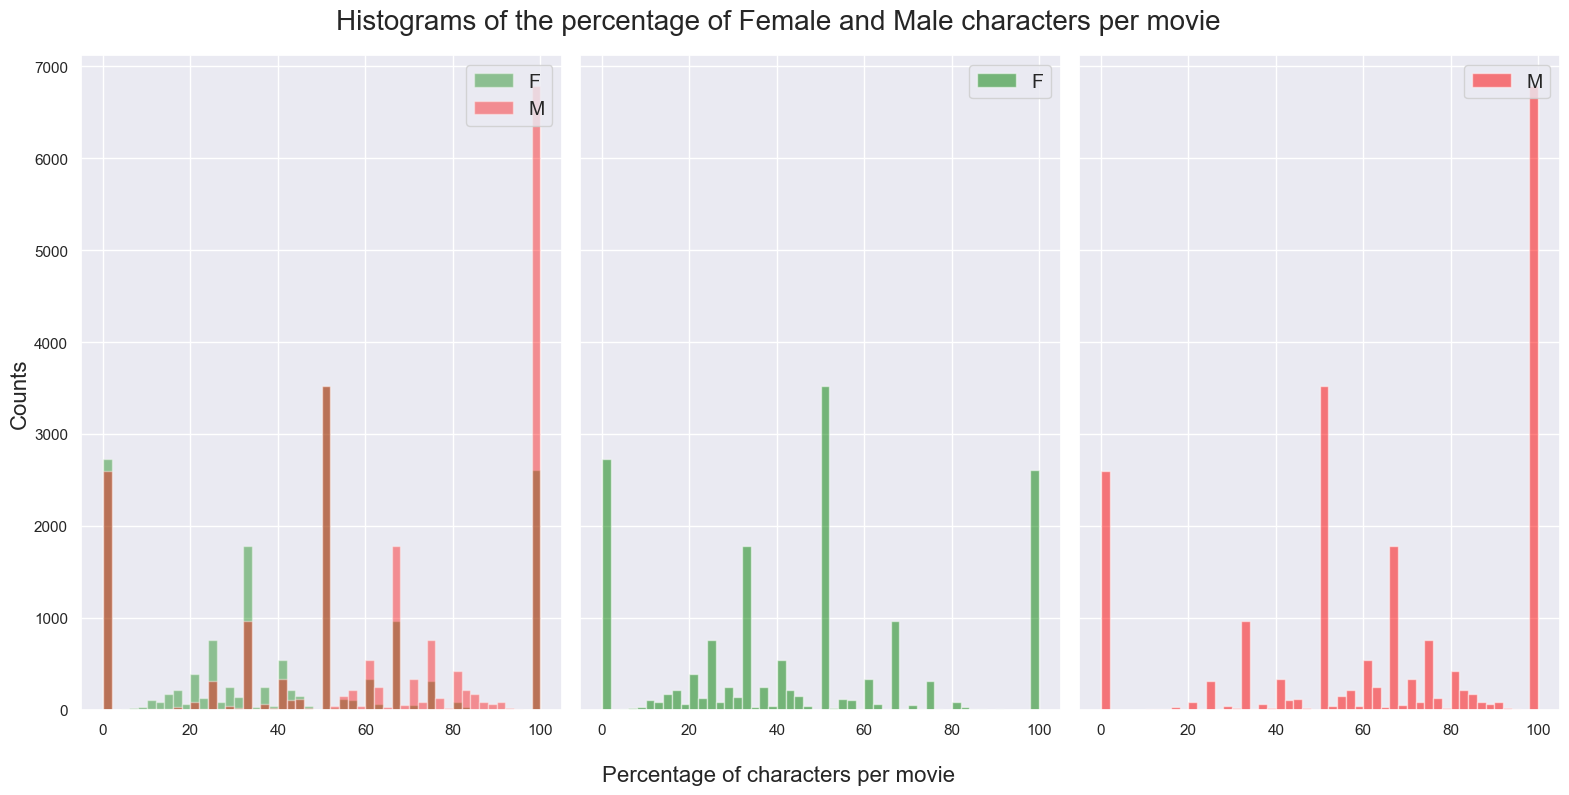

In [227]:
df_gender_proportion_by_movie=pd.DataFrame()

df_gender_proportion_by_movie['MaleCharacters'] = men_cmu.groupby('WikiMovieID')['CharacterName'].nunique()
df_gender_proportion_by_movie['FemaleCharacters'] = women_cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie['TotalNumberofCharacters'] = cmu.groupby('WikiMovieID')['CharacterName'].nunique()

df_gender_proportion_by_movie = df_gender_proportion_by_movie.merge(cmu[['ReleaseYear', 'WikiMovieID', 'Countries', 'Continent']], how='left', left_index=True, right_on='WikiMovieID' )

df_gender_proportion_by_movie['PercentageofFemale'] = df_gender_proportion_by_movie['FemaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100
df_gender_proportion_by_movie['PercentageofMale'] = df_gender_proportion_by_movie['MaleCharacters'] / df_gender_proportion_by_movie['TotalNumberofCharacters'] * 100

df_gender_proportion_by_movie =df_gender_proportion_by_movie.drop_duplicates(subset=['WikiMovieID'])

#Plot
fig, ax = plt.subplots(1, 3, figsize=(16,8), sharey=True)

ax[0].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.4, color='green')
ax[0].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.4, color='red')
ax[0].legend(loc='upper right', fontsize=14) 

ax[1].hist(df_gender_proportion_by_movie['PercentageofFemale'], bins=50, label='F', alpha=0.5, color='green')
ax[1].legend(loc='upper right', fontsize=14) 


ax[2].hist(df_gender_proportion_by_movie['PercentageofMale'], bins=50, label='M', alpha=0.5, color='red')
ax[2].legend(loc='upper right', fontsize=14) 

fig.supxlabel('Percentage of characters per movie', fontsize=16)
fig.supylabel('Counts', va='center', rotation=90, fontsize=16)
fig.suptitle('Histograms of the percentage of Female and Male characters per movie', fontsize=20)

plt.tight_layout()

plt.show()

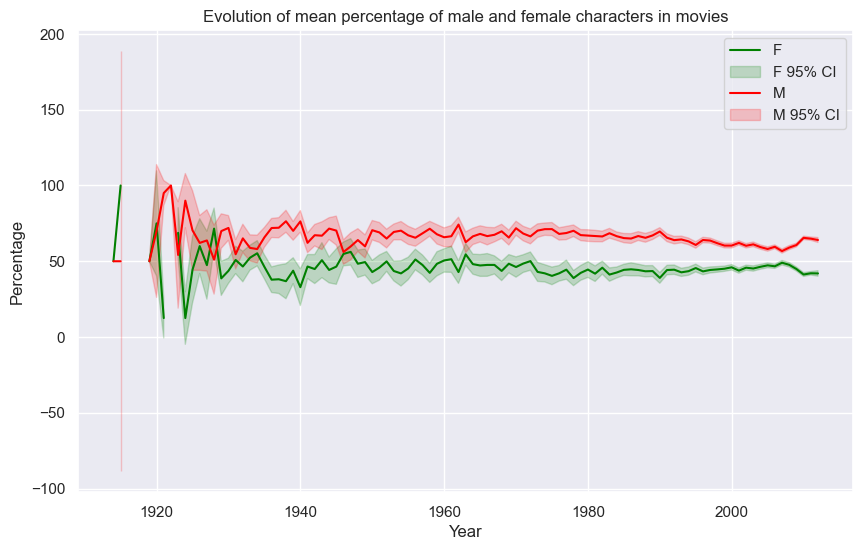

In [228]:
#Calculate the mean percentage of actors and actresses in movies across year
percentage_of_women_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofFemale':'std'})
men_std_perc_per_year = df_gender_proportion_by_movie.groupby('ReleaseYear').agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women = percentage_of_women_by_movie['PercentageofFemale'] + z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_women = percentage_of_women_by_movie['PercentageofFemale'] - z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

upper_bound_men = percentage_of_men_by_movie['PercentageofMale'] + z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_men = percentage_of_men_by_movie['PercentageofMale'] - z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby('ReleaseYear').agg({'CharacterName': 'count'})['CharacterName'])

#Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(percentage_of_women_by_movie, label='F', color='green')
ax.fill_between(lower_bound_women.index, lower_bound_women, upper_bound_women, alpha =0.2, color='green', label = 'F 95% CI')

ax.plot(percentage_of_men_by_movie, label='M', color='red')
ax.fill_between(lower_bound_men.index, lower_bound_men, upper_bound_men, alpha =0.2, color='red', label = 'M 95% CI')

#ax.set_ylim(0,101)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')
ax.set_title('Evolution of mean percentage of male and female characters in movies')
ax.legend()
plt.show()

### GENRE OF MOVIE: IS THERE A DIFFERENCE ?

An often-repeated stereotype regarding women suggests that they are not inclined towards action, sports, or intellectual pursuits, but rather, their primary role is portrayed as being centered around romantic relationships. We aim to investigate whether this stereotype is reflected in the portrayal of women in movies from our dataset.

We will do our analysis only based on the 16 major genres of movie in the dataset. First, we need to determine what these 16 genres are.

In [122]:
# Filter the cmu dataset to get only 1 row per movie. Otherwise, the genres are counted too many times
cmu_without_duplicates = cmu.drop_duplicates(subset=['WikiMovieID'], keep='first')

In [123]:
all_unique_genres = set()

# Get all the movie genres
cmu_without_duplicates['MovieGenre'].apply(lambda x: all_unique_genres.update(x.values()) if isinstance(x, dict) else None)

# Initialize dictionary with keys and values set to 0
genres_count = {genre: 0 for genre in all_unique_genres}

# Count the occurence of each genre
for row in cmu_without_duplicates['MovieGenre']:
    for key, value in row.items():
        genres_count[value]+=1
        
# Sort the dictionary by values in descending order
genres_count = dict(sorted(genres_count.items(), key=lambda item: item[1], reverse=True))

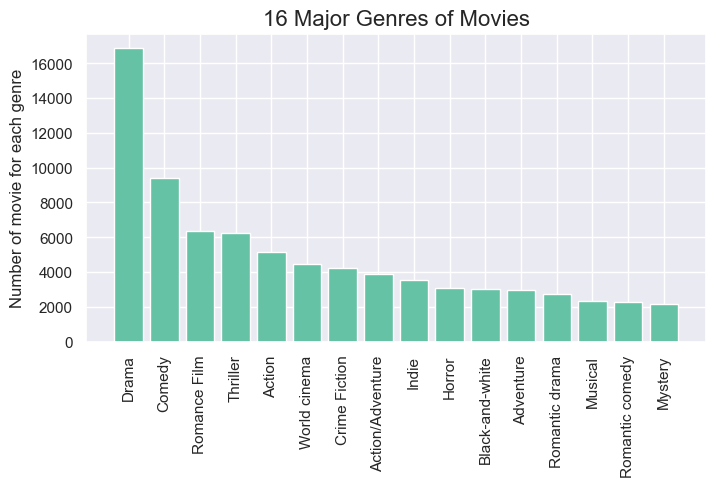

In [124]:
plt.figure(figsize=(8, 4))

# Keep the first 16 major genres
major_16_genres = dict(islice(genres_count.items(), 16))

x = np.arange(len(major_16_genres))

plt.bar(x, major_16_genres.values())
plt.xticks(x, major_16_genres.keys(), rotation='vertical')
plt.title('16 Major Genres of Movies', fontsize=16)
plt.ylabel('Number of movie for each genre')
plt.show()

For the analysis we consider that:
- If a movie has several genres, we will keep the one that appears in the 16 major genres, and if several are in the 16 major genres, we keep the first one.
- If none is in the 16 major genre, or if the genre is not given, then we drop the row

In [125]:
# List of rows to drop 
rows_to_drop = []

cmu_genre = cmu.copy()

for index, row in cmu_genre.iterrows():
    movie_genre = row['MovieGenre']
    
    # If there is one genre only, drop the row if not in the 16 major genre
    if len(movie_genre) == 1 and list(movie_genre.values())[0] not in major_16_genres:
        rows_to_drop.append(index)
        
    # If there is no genre, drop the corresponding row
    elif not bool(movie_genre):
        rows_to_drop.append(index)
            
    # If there are multiple genres        
    else:
        count = 0  # To keep the first value only
        for key, value in movie_genre.items():
            if value in major_16_genres:
                if count == 0:
                    value_to_keep = value
                    key_to_keep = key
                    count = 1
                    break

        if count == 0:  # If none of the genres is in the major_16_genres, drop the row
            rows_to_drop.append(index)

        if count == 1:
            cmu_genre.at[index, 'MovieGenre'] = {key_to_keep: value_to_keep}

# Create a new DataFrame with only the rows to keep
cmu_genre = cmu_genre.drop(rows_to_drop)
movie_counts = cmu_genre['WikiMovieID'].nunique()
print(f'We are left with {movie_counts} movies')

We are left with 31138 movies


To facilitate analysis, we replace the dictionary for the 'MovieGenre' column with a str:

In [126]:
cmu_genre['MovieGenre'] = cmu_genre['MovieGenre'].apply(lambda x: list(x.values())[0])

In [127]:
# Split the dataset in 2 according to actor gender
women_with_genre = cmu_genre.loc[cmu_genre['Gender']=='F'].copy(deep=True)
men_with_genre = cmu_genre.loc[cmu_genre['Gender']=='M'].copy(deep=True)

In [128]:
# Group by 'MovieGenre' and count the number of occurence
women_genre_counts = women_with_genre.groupby('MovieGenre').size().reset_index(name='Women_Count')
men_genre_counts = men_with_genre.groupby('MovieGenre').size().reset_index(name='Men_Count')

# New dataframe with the counts
genre_counts = women_genre_counts.merge(men_genre_counts, how='left', on='MovieGenre')

# Compute the percentage of Women and Men per movie genre
genre_counts['Percent_Women']=(genre_counts['Women_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100
genre_counts['Percent_Men']=(genre_counts['Men_Count']/(genre_counts['Women_Count']+genre_counts['Men_Count']))*100

In [129]:
genre_counts.sample(2)

,MovieGenre,Women_Count,Men_Count,Percent_Women,Percent_Men
2,Adventure,2104,5165,28.944834,71.055166
3,Black-and-white,343,606,36.143309,63.856691


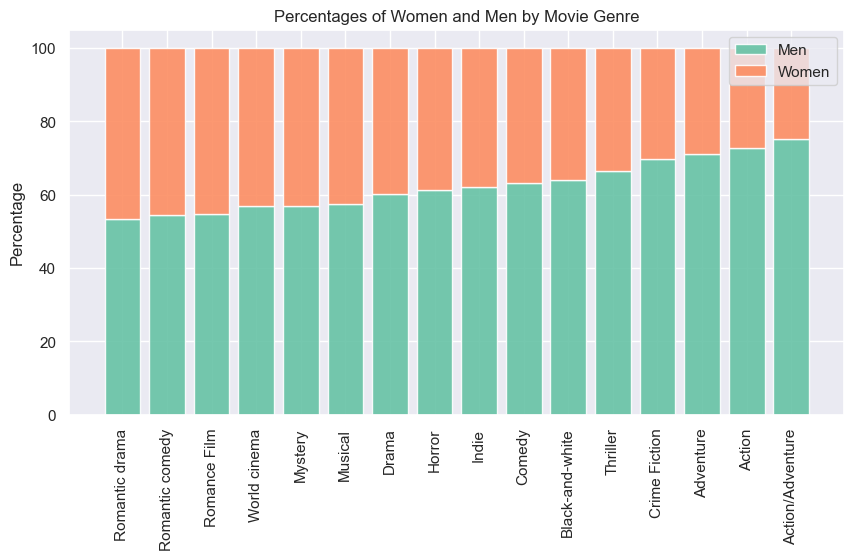

In [130]:
# Plot the percentage of Women and Men per movie genre

# Sort the DataFrame for better visualization
genre_counts = genre_counts.sort_values(by='Percent_Men', ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Men'], label='Men', alpha=0.9)
ax.bar(genre_counts['MovieGenre'], genre_counts['Percent_Women'], bottom=genre_counts['Percent_Men'], label='Women', alpha=0.9)

plt.xticks(rotation='vertical')
ax.set_ylabel('Percentage')
ax.set_title('Percentages of Women and Men by Movie Genre')
ax.legend()

plt.show()

Is there a difference in actors' ages between genres? 

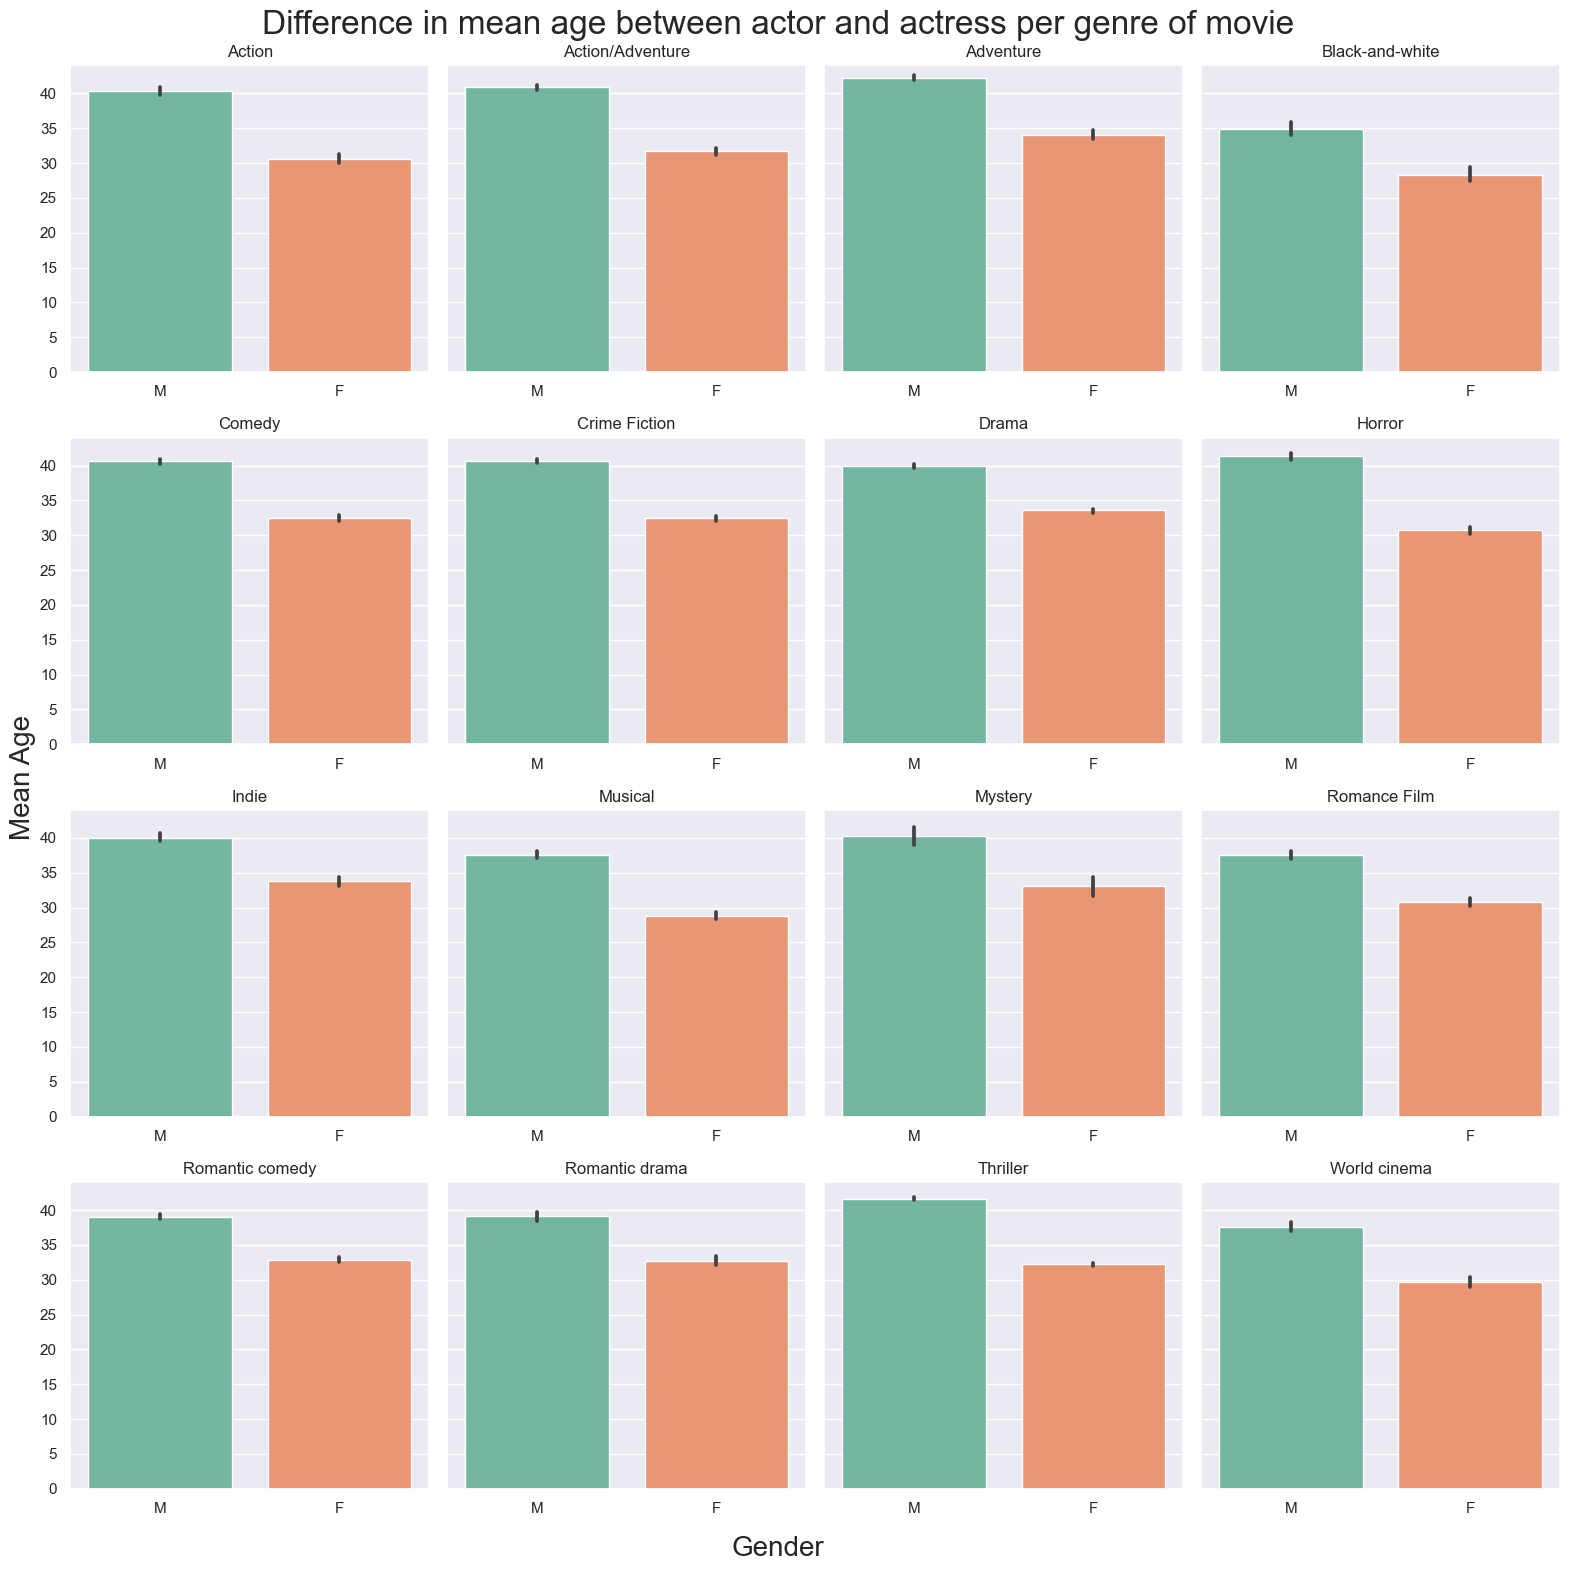

In [131]:
cmu_by_genre = cmu_genre.groupby('MovieGenre')

fig, axes = plt.subplots(4,4,figsize= (16,16), sharey=True)

for genre, ax in zip(cmu_by_genre.groups.keys(), axes.flat):
    sns.set(style="darkgrid", palette="Set2")
    
    plot = sns.barplot(x='Gender', y='Age', data=cmu_by_genre.get_group(genre), ax=ax, order=['M', 'F'], errorbar=('ci',95))
    plot.set_title(genre)
    plot.set(ylabel=None)
    plot.set(xlabel=None)
    plot.set(ylim = (0,44))

fig.supxlabel('Gender', fontsize=20)
fig.supylabel('Mean Age', va='center', rotation=90, fontsize=20)
fig.suptitle('Difference in mean age between actor and actress per genre of movie', fontsize=24)

plt.tight_layout()

plt.show()

Across all genres we observe a similar inequality in the average age of actors and actresses. Actresses are generally younger in all movie genres and the difference is significant when looking at the small 95 % confidence intervals

### What is the typical carrier of men and women ?

In [132]:
movies_per_actress = women_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')
movies_per_actor = men_cmu.groupby('ActorName').size().reset_index(name='number_of_movies')

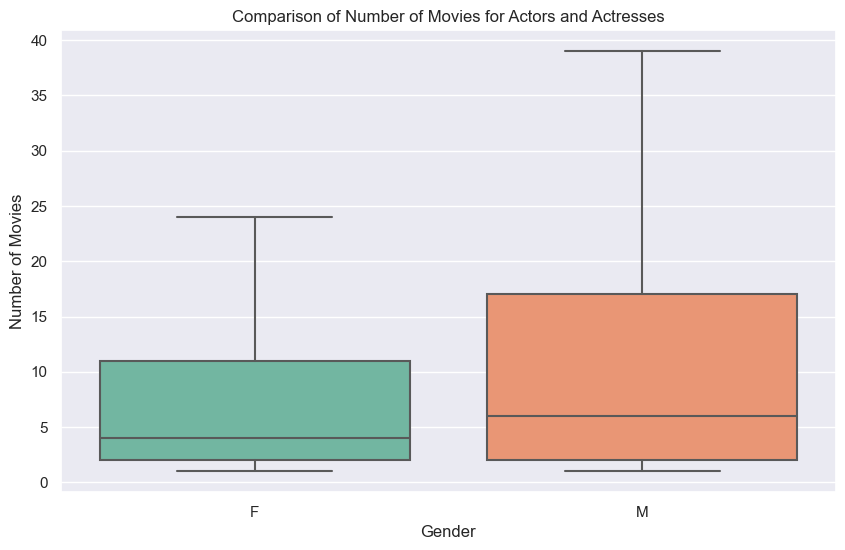

In [133]:
# Combine the two DataFrames into a single DataFrame
movies_per_actor_and_actress = pd.concat([movies_per_actress.assign(gender='F'), 
                                          movies_per_actor.assign(gender='M')])

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='number_of_movies', data=movies_per_actor_and_actress, showfliers=False)
plt.xlabel('Gender')
plt.ylabel('Number of Movies')
plt.title('Comparison of Number of Movies for Actors and Actresses')
plt.show()

## PART 2: Qualitative analysis of gender representation in movies <a id="part2"></a>

### What are the types of characters women interpret ? 

Let's uncover whether the common stereotypes about women align with the characters we observe on the screen.


For this analysis, we will use the tvtropes.clusters file

In [134]:
with open(CHARACTER_TYPE_PATH, 'r') as file:
    lines = file.readlines()
    new_lines = []
    
    for line in lines:
        char_type = line.split()[0]
        char_type_dict = {'CharType': char_type}

        space_index = line.find('	')
        char_info = ast.literal_eval(line[space_index+1:])
        
        new_line = {**char_type_dict, **char_info}
        
        new_lines.append(new_line)
    

# Evaluate each line and extract the column name and corresponding dictionary

headers_names = ['CharType',
                 'CharName',
                 'MovieName',
                 'FreebaseActorMapID',
                 'ActorName']

chartypes = pd.DataFrame(new_lines)
chartypes.columns = headers_names
chartypes.head()

FileNotFoundError: [Errno 2] No such file or directory: 'tvtropes.clusters.txt'

In [ ]:
chartype_cmu = cmu.merge(chartypes, how='right', on=['FreebaseActorMapID', 'MovieName'])
chartype_women = chartype_cmu.loc[chartype_cmu['Gender']=='F'].copy(deep=True)
chartype_men = chartype_cmu.loc[chartype_cmu['Gender']=='M'].copy(deep=True)

NameError: name 'chartypes' is not defined

In [ ]:
women_counts = chartype_women['CharType'].value_counts().head(5)
men_counts = chartype_men['CharType'].value_counts().head(5)

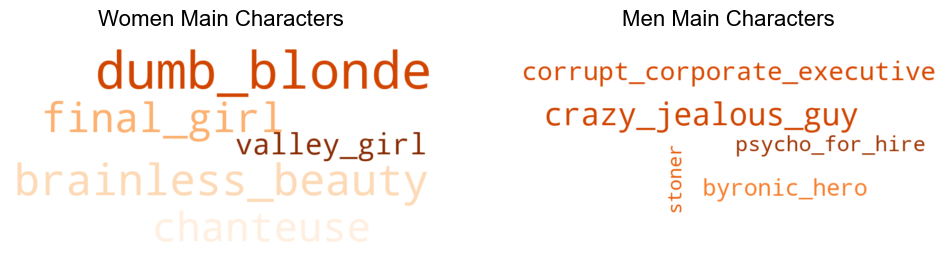

In [ ]:
# Create WordClouds for women and men
women_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(women_counts)
men_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(men_counts)

# Plotting the WordClouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(women_wordcloud, interpolation='bilinear')
plt.title('Women Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(men_wordcloud, interpolation='bilinear')
plt.title('Men Main Characters', color='black', fontsize=16)
plt.axis('off')

plt.show()

## PART 3: Analysis of the reception of movies by the public <a id="part3"></a>

### Is there a difference in revenue and popularity between female-dominated and male-dominated films?

We want to analyse whether the success of a movie is correlated with the proportion of women in a movie. To to this we will take the Box Office Revenue as a measure of success, as well as the IMDb ratings given around the world to each movie.

### Looking at the ratings

In [ ]:
# IMDb data set merged with the CMU movies
ratings = pd.read_csv(RATINGS_PATH, sep='\t',)
ratings.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,ReleaseYear,AverageRating,NumberofVotes
848,19233817,/m/04ld_2x,Younger and Younger,1993,NaN,99.0,{'/m/02h40lc': 'English Language'},"{'/m/09c7w0': 'United States of America', '/m/...","{""/m/07s9rl0"": ""Drama"", ""/m/0vgkd"": ""Black com...",1993.0,4.9,628.0
952,20135224,/m/04ybs49,Fuel,2008,NaN,111.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{""/m/0cshrf"": ""Political cinema"", ""/m/0219x_"":...",2008.0,7.3,781.0


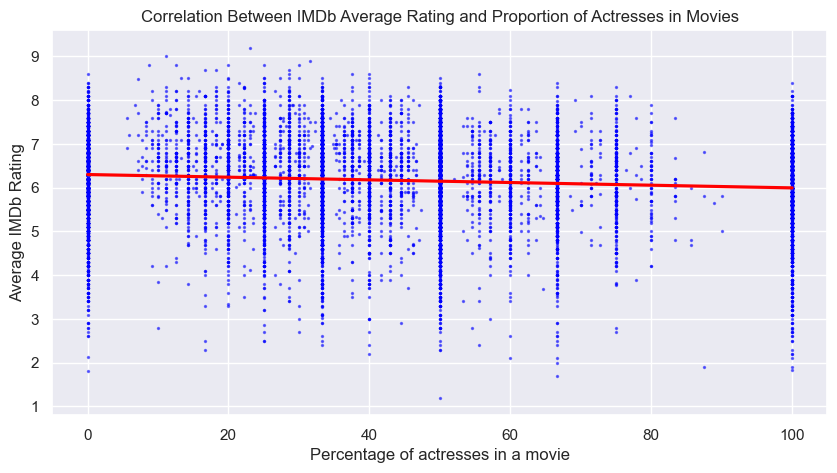

In [ ]:
# We're interested only in movies for which we have information on gender distribution, so we perform a right join
ratings_gender = pd.merge(ratings, df_gender_proportion_by_movie, on='WikiMovieID', how='right')

# Sort the values according to Percentage of Female 
ratings_gender.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=ratings_gender['PercentageofFemale'], y=ratings_gender['AverageRating'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.ylabel('Average IMDb Rating')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between IMDb Average Rating and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the rating given on IMDb. This shows us that there is a slight negative correlation, meaning that movies with a higher percentage of women tend to have a slightly worse rating. We need to check this with other statistical metrics. 

### Looking at the Box office revenue

Aside from how a movie has been rated on IMDb, it is also interesting to look at its comercial success. This gives another insight on how the movie was globally percieved and if it impacted a lot of people or not. Therefore we are now looking at the boxoffice revenue of movies where we have the information from the original CMU data set. 

/var/folders/ky/pdhdq4m936n0fk__0t1jt_hw0000gn/T/ipykernel_41781/2691133020.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BO_ratings.sort_values(by='PercentageofFemale', inplace=True)


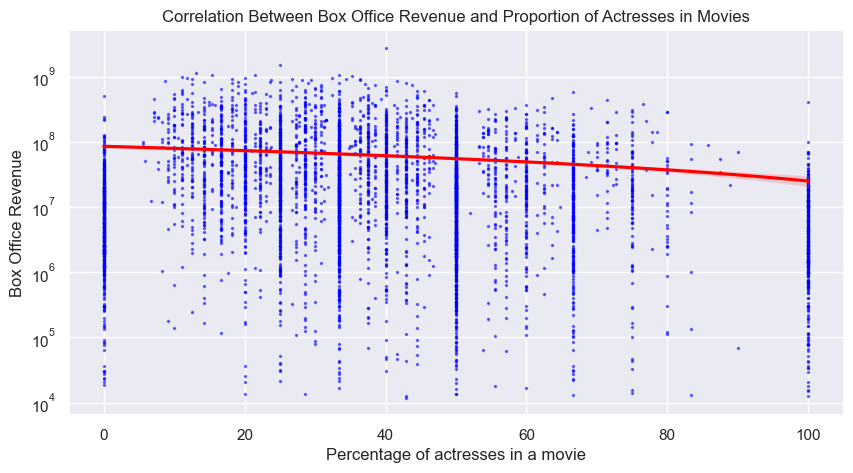

In [ ]:
# Remove movies where we don't have the Box Office Revenue.
BO_ratings = ratings_gender.dropna(subset = 'BORevenue')

# Sort the values according to Percentage of Female 
BO_ratings.sort_values(by='PercentageofFemale', inplace=True)

plt.figure(figsize=(10,5))

sns.regplot(x=BO_ratings['PercentageofFemale'], y=BO_ratings['BORevenue'], ci=95, scatter_kws={'color': 'blue', 's': 2, 'alpha': 0.5}, line_kws={'color': 'red'})

plt.yscale("log")
plt.ylabel('Box Office Revenue')
plt.xlabel('Percentage of actresses in a movie')

plt.title('Correlation Between Box Office Revenue and Proportion of Actresses in Movies')

plt.show()

We do a linear regression to see the correlation between the percentage of women in movies and the Box Office Revenue. This shows us that there is a negative correlation, meaning that movies with a higher percentage of women tend to have a lower Box Office Revenue. We need to check this with other statistical metrics. 

## PART 4: Analysis by geographical production region <a class="anchor" id="part4"></a>

### Do we have enough movies per continent ?

In [136]:
# Keep only 1 row per movie to count the number of movies per continent
cmu_countries_filtered = cmu.drop_duplicates(subset=['MovieName', 'ReleaseYear', 'Continent'])
counts_per_continent = cmu_countries_filtered.groupby('Continent').size()

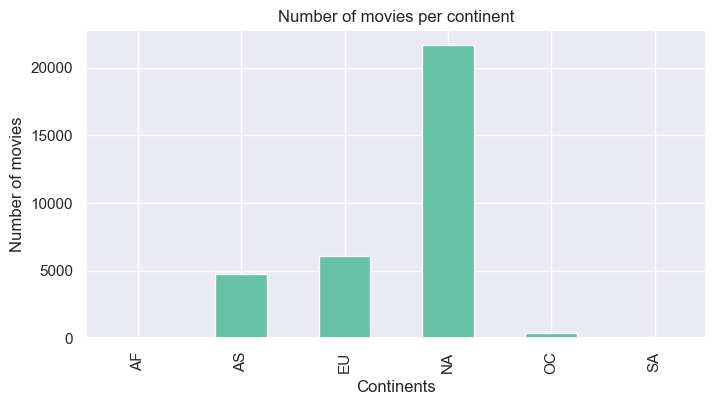

In [137]:
plt.figure(figsize=(8, 4))
counts_per_continent.plot(kind='bar')

plt.xlabel('Continents')
plt.ylabel('Number of movies')
plt.title('Number of movies per continent')

plt.show()

### Gender proportion split by geographical area

In [ ]:
cmu_countries_filtered.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear,Continent
203988,77663,/m/0kb9y,Madame Curie,1943-12-15,NaN,124.0,{'/m/02h40lc': 'English Language'},[US],"{'/m/017fp': 'Biography', '/m/01f9r0': 'Docudr...",NaN,F,1.67,/m/07bch9,Greer Garson,39.0,/m/02vczj1,NaN,/m/0h1s0,1943.0,NA
26898,12780330,/m/02x4myp,The Sting of Death,1990,NaN,115.0,{'/m/03_9r': 'Japanese Language'},[JP],"{'/m/0gw5n2f': 'Japanese Movies', '/m/07s9rl0'...",NaN,F,1.60,NaN,Keiko Matsuzaka,37.0,/m/040jqpc,NaN,/m/0277x5t,1990.0,AS


In [ ]:
# convert list in string
cmu_countries['Countries'] = cmu_countries['Countries'].apply(lambda x: x[0] if isinstance(x, list) else x)
cmu_countries.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Languages,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,ActorName,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear,Continent
329835,19863623,/m/04q2jwq,Dharma Dorai,1991,NaN,150.0,{'/m/07c9s': 'Tamil Language'},IN,"{'/m/07s9rl0': 'Drama', '/m/03q4nz': 'World ci...",NaN,F,1.651,NaN,Madhoo,18.0,/m/02vcj5t,NaN,/m/07fm_x,1991.0,AS
212097,31917188,/m/021_k4v,Here come the Waves,1944-12-18,NaN,100.0,{'/m/02h40lc': 'English Language'},US,"{'/m/06cvj': 'Romantic comedy', '/m/06qm3': 'S...",NaN,M,1.700,/m/033tf_,Bing Crosby,41.0,/m/04hvbs9,NaN,/m/01vsy9_,1944.0,NA


In [243]:
# Proportion of gender in USA
df_gender_proportion_by_movie_us = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Countries'] == 'US']
df_gender_proportion_by_movie_us.sample(2)


,MaleCharacters,FemaleCharacters,TotalNumberofCharacters,ReleaseYear,WikiMovieID,Countries,Continent,PercentageofFemale,PercentageofMale
137819,0,0.0,0,2004.0,2416538,US,NA,NaN,NaN
184208,1,0.0,1,1980.0,6185648,US,NA,0.0,100.0


In [244]:
# Proportion of gender in Europe
df_gender_proportion_by_movie_europe = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Continent'] == 'EU']
df_gender_proportion_by_movie_europe.sample(2)

,MaleCharacters,FemaleCharacters,TotalNumberofCharacters,ReleaseYear,WikiMovieID,Countries,Continent,PercentageofFemale,PercentageofMale
41854,1,1.0,2,2009.0,10239839,GB,EU,50.0,50.0
353700,0,NaN,0,1979.0,13649711,GB,EU,NaN,NaN


In [245]:
# Proportion of gender in India
df_gender_proportion_by_movie_india = df_gender_proportion_by_movie[df_gender_proportion_by_movie['Countries'] == 'IN']
df_gender_proportion_by_movie_india.sample(2)

,MaleCharacters,FemaleCharacters,TotalNumberofCharacters,ReleaseYear,WikiMovieID,Countries,Continent,PercentageofFemale,PercentageofMale
43828,1,NaN,1,1957.0,11624958,IN,AS,NaN,100.0
350848,1,0.0,1,2004.0,5051407,IN,AS,0.0,100.0


In [246]:
#Calculate the mean percentage of actors and actresses in movies across year in US
percentage_of_women_by_movie = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofFemale':'mean'})
percentage_of_men_by_movie = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofMale':'mean'})

#Calculate the 95% CIs
women_std_perc_per_year = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofFemale':'std'})
men_std_perc_per_year = df_gender_proportion_by_movie.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'PercentageofMale':'std'})

z=1.96
upper_bound_women = percentage_of_women_by_movie['PercentageofFemale'] + z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_women = percentage_of_women_by_movie['PercentageofFemale'] - z*women_std_perc_per_year['PercentageofFemale']/np.sqrt(women_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])

upper_bound_men = percentage_of_men_by_movie['PercentageofMale'] + z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])
lower_bound_men = percentage_of_men_by_movie['PercentageofMale'] - z*men_std_perc_per_year['PercentageofMale']/np.sqrt(men_cmu.groupby(['ReleaseYear', 'Countries', 'Continent']).agg({'CharacterName': 'count'})['CharacterName'])


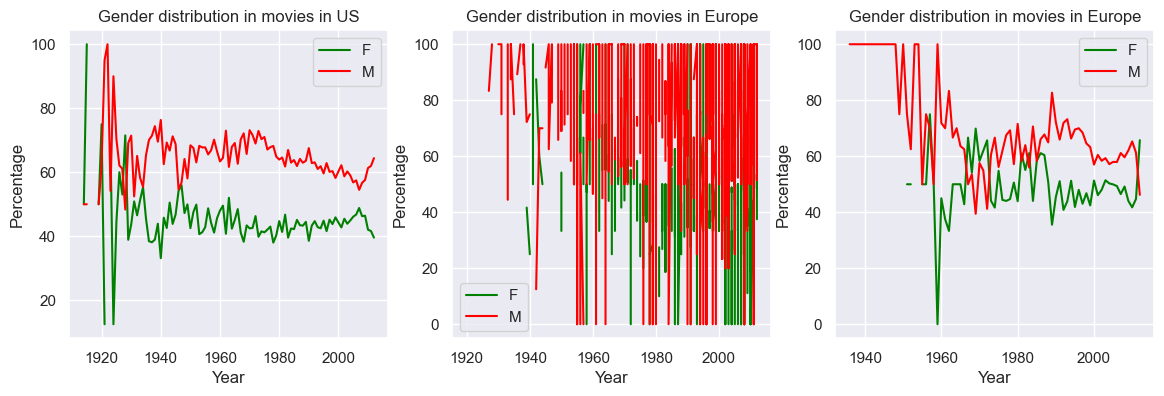

In [247]:
# Plot gender distribution for US, Europe and India
percentage_of_women_by_movie_us = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Countries') == 'US']
lower_bound_women_us = lower_bound_women[lower_bound_women.index.get_level_values('Countries') == 'US']
upper_bound_women_us = upper_bound_women[upper_bound_women.index.get_level_values('Countries') == 'US']
percentage_of_men_by_movie_us = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Countries') == 'US']
lower_bound_men_us = lower_bound_men[lower_bound_men.index.get_level_values('Countries') == 'US']
upper_bound_men_us = upper_bound_men[upper_bound_men.index.get_level_values('Countries') == 'US']

percentage_of_women_by_movie_eu = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Continent') == 'EU']
lower_bound_women_eu = lower_bound_women[lower_bound_women.index.get_level_values('Continent') == 'EU']
upper_bound_women_eu = upper_bound_women[upper_bound_women.index.get_level_values('Continent') == 'EU']
percentage_of_men_by_movie_eu = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Continent') == 'EU']
lower_bound_men_eu = lower_bound_men[lower_bound_men.index.get_level_values('Continent') == 'EU']
upper_bound_men_eu = upper_bound_men[upper_bound_men.index.get_level_values('Continent') == 'EU']

percentage_of_women_by_movie_in = percentage_of_women_by_movie[percentage_of_women_by_movie.index.get_level_values('Countries') == 'IN']
lower_bound_women_in = lower_bound_women[lower_bound_women.index.get_level_values('Countries') == 'IN']
upper_bound_women_in = upper_bound_women[upper_bound_women.index.get_level_values('Countries') == 'IN']
percentage_of_men_by_movie_in = percentage_of_men_by_movie[percentage_of_men_by_movie.index.get_level_values('Countries') == 'IN']
lower_bound_men_in = lower_bound_men[lower_bound_men.index.get_level_values('Countries') == 'IN']
upper_bound_men_in = upper_bound_men[upper_bound_men.index.get_level_values('Countries') == 'IN']

fig, ax = plt.subplots(1, 3, figsize=(14,4))

ax[0].plot(percentage_of_women_by_movie_us.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_us['PercentageofFemale'], label='F', color='green')
#ax[0].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[0].plot(percentage_of_men_by_movie_us.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_us['PercentageofMale'], label='M', color='red')
#ax[0].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Gender distribution in movies in US')
ax[0].legend()

ax[1].plot(percentage_of_women_by_movie_eu.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_eu['PercentageofFemale'], label='F', color='green')
#ax[1].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[1].plot(percentage_of_men_by_movie_eu.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_eu['PercentageofMale'], label='M', color='red')
#ax[1].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Percentage')
ax[1].set_title('Gender distribution in movies in Europe')
ax[1].legend()

ax[2].plot(percentage_of_women_by_movie_in.index.get_level_values('ReleaseYear'), percentage_of_women_by_movie_in['PercentageofFemale'], label='F', color='green')
#ax[2].fill_between(lower_bound_women_us.index, lower_bound_women_us, upper_bound_women_us, alpha =0.2, color='green', label = 'F 95% CI')
ax[2].plot(percentage_of_men_by_movie_in.index.get_level_values('ReleaseYear'), percentage_of_men_by_movie_in['PercentageofMale'], label='M', color='red')
#ax[2].fill_between(lower_bound_men_us.index, lower_bound_men_us, upper_bound_men_us, alpha =0.2, color='red', label = 'M 95% CI')
ax[2].set_xlabel('Year')
ax[2].set_ylabel('Percentage')
ax[2].set_title('Gender distribution in movies in Europe')
ax[2].legend()